In [1]:
%matplotlib inline
%reload_ext autoreload
import os
import pandas as pd
import matplotlib.pyplot as plt
import math
import json
import itertools
import datetime
import seaborn as sns
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics.pairwise import cosine_similarity
import re
import random
import numpy as np
import shutil
from tqdm import tqdm_notebook as tq
import time
from collections import Counter, defaultdict
from IPython.display import clear_output, display
plt.rcParams['figure.figsize'] = [12, 8]
flatten_list = lambda x: list(itertools.chain.from_iterable(x))

/Users/orenmatar/.pyenv/versions/3.8.0/envs/forecasting_env/lib/python3.8/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [3]:
to_var = lambda x: Variable(torch.from_numpy(np.array(x))).float()

In [4]:
class MultipleRegression(nn.Module):
    def __init__(self, num_regression, input_dim, selector_dim=None):
        super(MultipleRegression, self).__init__()
        if selector_dim is None:
            selector_dim = input_dim
        self.regressions = nn.Linear(input_dim, num_regression)
        self.selector_regressions = nn.Linear(selector_dim, num_regression)
        self.s = nn.Softmax(dim=1)

    def forward(self, X, selector_X):
        outputs = self.regressions(X)
        selector = self.s(self.selector_regressions(selector_X))
        res = (selector*outputs).sum(dim=1)
        return selector, outputs, res
    
    def norm_data(self, X, selector_X=None, y=None):
        X_norm = (X-self.x_mean)/self.x_std
        y_norm=None
        if y is not None:
            y_norm = (y-self.y_mean)/self.y_std
            
        selector_X_norm=None
        if selector_X is not None:
            selector_X_norm = (selector_X-self.selector_X_mean)/self.selector_X_std
        return X_norm, selector_X_norm, y_norm
    
    def fit(self, X, y, selector_X=None, num_epochs=1000, half_loss=0, max_loss=0):
#         TODO: maybe add dataloader + batches
        if selector_X is None:
            selector_X = X
        X = np.array(X)
        y = np.array(y)
        selector_X = np.array(selector_X)

        networks_params = list(self.regressions.parameters())
        self_params = list(self.parameters())
        optimizer = optim.Adam(networks_params+self_params, 0.01)
        loss_func = torch.nn.MSELoss()
        selector_loss_f = nn.BCELoss()
        
        self.x_mean = X.mean(axis=0)
        self.selector_X_mean = selector_X.mean(axis=0)
        self.y_mean = y.mean()
        self.x_std = X.std(axis=0)
        self.selector_X_std = selector_X.std(axis=0)
        self.y_std = y.std()
        
        X_norm, selector_X_norm, y_norm = self.norm_data(X, selector_X, y)
        
        X_t = to_var(X_norm)
        y_t = to_var(y_norm)
        s_X_t = to_var(selector_X_norm)

        for i in range(num_epochs):
            tot_loss = 0
            selector, outputs, predictions = self(X_t, s_X_t)
            optimizer.zero_grad()
            prediction_loss = loss_func(predictions, y_t)
            
            selector_max = selector.max(dim=1)[0]
            selector_max_loss = selector_loss_f(selector_max, torch.ones(len(selector_max)))
            selector_half_loss = -((0.5 - selector)**2).mean()
            
            loss = prediction_loss + selector_half_loss*half_loss + selector_max_loss*max_loss
            
            loss.backward()
            optimizer.step()
            tot_loss += loss.item()
            if i%200 == 0:
                print(tot_loss)
                
    def predict(self, X, selector_X = None):
        if selector_X is None:
            selector_X = X
        X = np.array(X)
        selector_X = np.array(selector_X)
        X_norm, selector_X_norm, _ = self.norm_data(X, selector_X)
        
        with torch.no_grad():
            _, _, predictions = self.forward(to_var(X_norm), to_var(selector_X_norm))
        predictions = (predictions*self.y_std) + self.y_mean
        return predictions.numpy()
    
    def get_selector(self, selector_X):
        selector_X = np.array(selector_X)
        _, selector_X_norm, _ = self.norm_data(selector_X, selector_X)
        with torch.no_grad():
            selector = self.s(self.selector_regressions(to_var(selector_X_norm)))
        return selector.numpy()
    
from scipy.stats import pearsonr

def score(preds, actual):
    return pearsonr(preds, actual)[0]**2
#     return ((preds-actual)**2).mean()

# simple polynomial examle

In [5]:
x_lin = np.linspace(-9, 7, 100)
y_lin = (x_lin+7) * (x_lin-5) * (x_lin+4) * (x_lin)
X_lin = x_lin.reshape(-1,1)

In [6]:
idx = list(range(len(X_lin)))
test_idx = np.random.choice(idx, 20)
train_idex = [i for i in idx if i not in test_idx]
X_lin_train = X_lin[train_idex]
X_lin_test = X_lin[test_idx]
y_lin_train = y_lin[train_idex]
y_lin_test = y_lin[test_idx]

In [7]:
rf = RandomForestRegressor(min_samples_leaf=5, max_depth=4)
rf.fit(X_lin_train, y_lin_train)
score(rf.predict(X_lin_train), y_lin_train), score(rf.predict(X_lin_test), y_lin_test)

(0.8508940210839296, 0.8003046783778897)

In [8]:
lr = LinearRegression()
lr.fit(X_lin_train, y_lin_train)
score(lr.predict(X_lin_train), y_lin_train), score(lr.predict(X_lin_test), y_lin_test)

(3.918467273910186e-05, 0.044245315182237746)

In [9]:
n_network = MLPRegressor(max_iter=20000, hidden_layer_sizes=(10, 10))
n_network.fit(X_lin_train, y_lin_train)
score(n_network.predict(X_lin_train), y_lin_train), score(n_network.predict(X_lin_test), y_lin_test)

(0.9994940804895194, 0.9997578635456317)

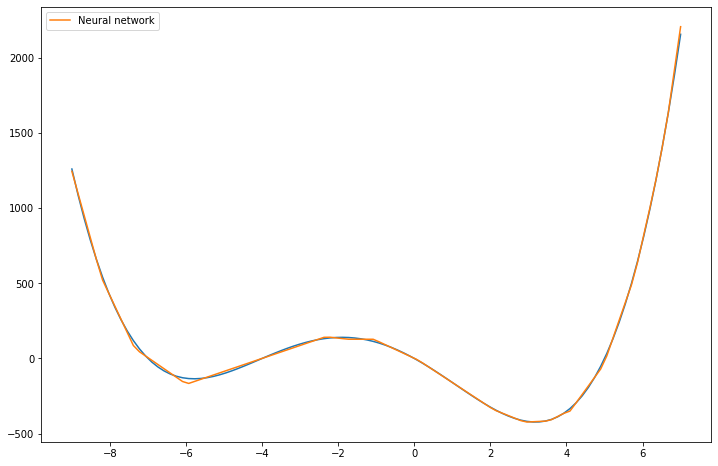

In [12]:
plt.plot(x_lin, y_lin)
plt.plot(x_lin, n_network.predict(X_lin), label='Neural network')
plt.legend()

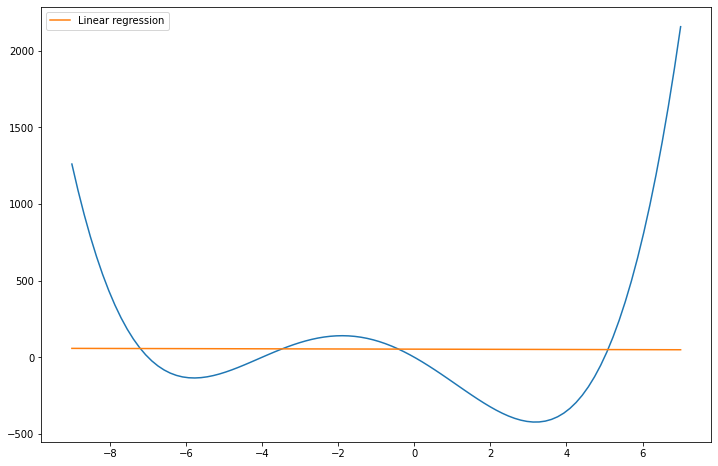

In [13]:
plt.plot(x_lin, y_lin)
plt.plot(x_lin, lr.predict(X_lin), label='Linear regression')
plt.legend()

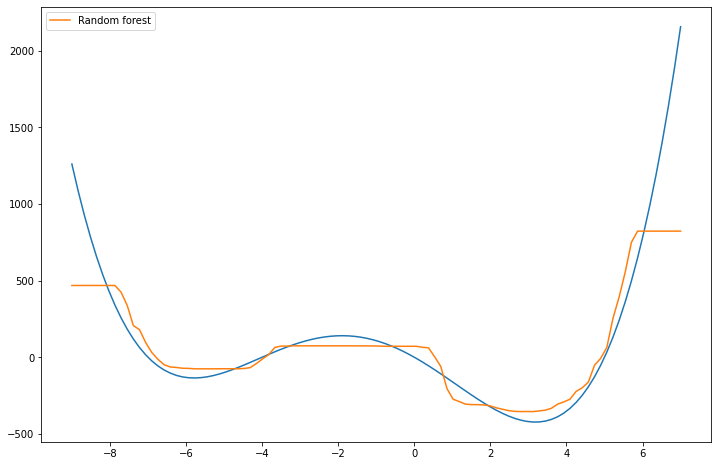

In [14]:
plt.plot(x_lin, y_lin)
plt.plot(x_lin, rf.predict(X_lin), label='Random forest')
plt.legend()
# note now badly it will generalize if in the test set/production we have values outside this range!

In [15]:
mnn_lin = MultipleRegression(3, 1)
mnn_lin.fit(X_lin_train, y_lin_train, half_loss=0., num_epochs=5000)
clear_output()
score(mnn_lin.predict(X_lin_train), y_lin_train), score(mnn_lin.predict(X_lin_test), y_lin_test)

(0.9970768537860165, 0.9981195188257079)

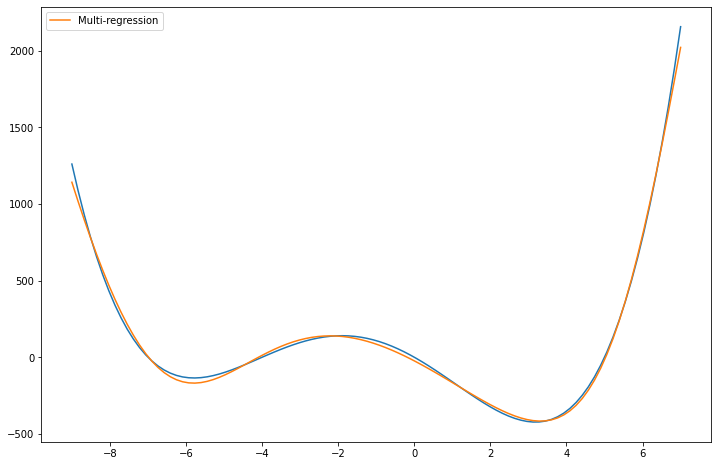

In [16]:
plt.plot(x_lin, y_lin)
plt.plot(x_lin, mnn_lin.predict(X_lin), label='Multi-regression')
plt.legend()

In [17]:
s = mnn_lin.get_selector(X_lin)
s = pd.DataFrame(s, index=X_lin.flatten())

In [18]:
s.round(3).sample(5)

,0,1,2
0.535354,0.008,0.979,0.013
0.858586,0.010,0.979,0.011
3.929293,0.114,0.884,0.001
4.737374,0.202,0.798,0.001
1.666667,0.019,0.974,0.006


In [19]:
reg_coefs = pd.Series(list(mnn_lin.regressions.parameters())[0].detach().numpy().flatten())
reg_bias = pd.Series(list(mnn_lin.regressions.parameters())[1].detach().numpy().flatten())

In [20]:
reg_coefs

0     6.392166
1    -2.374437
2   -10.837564
dtype: float32

In [21]:
reg_bias

0    -1.274446
1     0.672359
2   -16.720497
dtype: float32

In [22]:
# selector regression
sel_coefs = pd.Series(list(mnn_lin.selector_regressions.parameters())[0].detach().numpy().flatten())
sel_coefs

0    3.182429
1   -0.607884
2   -3.542745
dtype: float32

In [23]:
pd.DataFrame([reg_coefs,sel_coefs], index=['Regressions coefs', 'Selectors coefs']).T.round(2)

,Regressions coefs,Selectors coefs
0,6.39,3.18
1,-2.37,-0.61
2,-10.84,-3.54


# Boston housing dataset

In [24]:
from sklearn.datasets import load_boston
boston = load_boston()

In [25]:
print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [26]:
X_true = pd.DataFrame(boston['data'], columns=boston['feature_names'])
X = (X_true - X_true.mean())/X_true.std()
y = boston['target']

In [27]:
test_X = X.sample(int(0.2*len(X)))
train_X = X.drop(test_X.index)
y_test = y[test_X.index]
y_train = y[train_X.index]

In [28]:
lr = LinearRegression()
lr.fit(train_X, y_train)
score(lr.predict(train_X), y_train), score(lr.predict(test_X), y_test)

(0.7286221116979998, 0.7841258877969095)

In [29]:
rf = RandomForestRegressor()
rf.fit(train_X, y_train)
score(rf.predict(train_X), y_train), score(rf.predict(test_X), y_test)

(0.9798256800581223, 0.897487242275295)

In [30]:
# random initialization means that every run is a bit different
# run multiple times and select the best network based on a validation set

mnn = MultipleRegression(3, X.shape[1])
mnn.fit(train_X, y_train, half_loss=0., num_epochs=2500)
clear_output()

score(mnn.predict(train_X), y_train), score(mnn.predict(test_X), y_test)
# the fact that the train-test diff is smaller is important too - less overfit, more likely to work better on a slightly different test set/production
# same as we've seen in rf in the polinomial example

(0.9386670474389169, 0.8705241432035842)

In [32]:
s = pd.DataFrame(mnn.get_selector(X))
s

,0,1,2
0,0.000550,0.282195,0.717255
1,0.002976,0.188165,0.808859
2,0.017747,0.620463,0.361790
3,0.024420,0.615219,0.360361
4,0.018100,0.655034,0.326867
...,...,...,...
501,0.247805,0.245628,0.506566
502,0.161605,0.155866,0.682528
503,0.420950,0.448321,0.130729
504,0.370121,0.418567,0.211312


In [33]:
linear_models = pd.DataFrame(list(mnn.regressions.parameters())[0].detach().numpy(), columns=X.columns)
linear_models['intercept'] = list(mnn.regressions.parameters())[1].detach().numpy()

In [34]:
linear_models.round(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,intercept
0,-0.44,1.21,-1.27,0.4,-0.75,-1.29,1.76,-1.05,-0.09,2.27,0.20,0.72,-0.87,-0.90
1,-0.00,-0.04,0.86,-0.1,0.13,0.62,-0.78,-0.07,-0.25,-1.03,-0.24,-0.22,-0.25,0.59
2,-0.11,-0.01,-0.06,-0.0,-0.25,0.02,-0.14,-0.35,0.36,-0.35,-0.22,0.01,-0.06,-0.40


In [36]:
selector_model = pd.DataFrame(list(mnn.selector_regressions.parameters())[0].detach().numpy(), columns = X.columns)
selector_model['intercept'] = list(mnn.parameters())[1].detach().numpy()
selector_model.round(2)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,intercept
0,-0.03,0.72,0.54,0.26,-0.07,0.49,-0.11,-0.31,0.56,-0.28,1.41,-0.22,-0.70,-0.90
1,0.11,0.09,-0.42,0.08,0.28,0.61,0.40,0.33,0.22,0.11,-0.57,0.08,-0.15,0.59
2,-0.32,-0.09,-0.07,-0.05,0.05,-0.91,-0.29,0.19,-0.95,-0.66,-1.15,-0.03,0.98,-0.40


In [37]:
good_indicators = ['RM', 'DIS', 'INDUS', 'RAD']
good_indicators_map = {'RM': 'n_rooms', 'DIS': 'distance_to_center', 'INDUS': 'non_retail_business', 'CRIM': 'crime_rate', 'RAD': 'highway_access'}

In [38]:
linear_models[good_indicators].rename(good_indicators_map, axis=1).round(2)

,n_rooms,distance_to_center,non_retail_business,highway_access
0,-1.29,-1.05,-1.27,-0.09
1,0.62,-0.07,0.86,-0.25
2,0.02,-0.35,-0.06,0.36


In [39]:
selector_model[good_indicators].rename(good_indicators_map, axis=1).round(2)

,n_rooms,distance_to_center,non_retail_business,highway_access
0,0.49,-0.31,0.54,0.56
1,0.61,0.33,-0.42,0.22
2,-0.91,0.19,-0.07,-0.95


In [ ]:
- RAD      index of accessibility to radial highways
- RM       average number of rooms per dwelling
- DIS      weighted distances to five Boston employment centres
- CRIM     per capita crime rate by town
- INDUS    proportion of non-retail business acres per town

In [40]:
js = []
for i in range(3):
    idx = s[s[i] > 0.6].index
    j = X.loc[idx][good_indicators].rename(good_indicators_map, axis=1).round(2)
    display(j.sample(4))
    js.append(j)

,n_rooms,distance_to_center,non_retail_business,highway_access
426,-0.64,-0.85,1.01,1.66
372,-0.58,-1.27,1.01,1.66
369,0.57,-1.16,1.01,1.66
432,0.20,-0.76,1.01,1.66


,n_rooms,distance_to_center,non_retail_business,highway_access
182,1.24,-0.52,-1.26,-0.75
273,2.00,0.27,-0.61,-0.75
225,3.47,-0.43,-0.72,-0.18
390,-0.81,-0.89,1.01,1.66


,n_rooms,distance_to_center,non_retail_business,highway_access
168,0.05,-0.80,1.23,-0.52
502,-0.23,-0.72,0.12,-0.98
188,0.39,0.37,-1.12,-0.52
201,-0.17,1.18,-1.33,-0.87


In [43]:
linear_reg_per_item = pd.DataFrame(np.matmul(s.values, linear_models.drop('intercept', axis=1).values), columns=X.columns)

In [44]:
# the actual linear regression used for each item in the dataset, after the selector selected the right params...
linear_reg_per_item

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.078009,-0.016098,0.199663,-0.031717,-0.144614,0.190765,-0.317714,-0.273391,0.188823,-0.536860,-0.222987,-0.055349,-0.114702
1,-0.088682,-0.010671,0.110820,-0.021216,-0.182285,0.131434,-0.252103,-0.301282,0.245608,-0.466239,-0.220239,-0.031776,-0.098736
2,-0.048204,-0.004109,0.487878,-0.059101,-0.021964,0.370091,-0.504522,-0.191094,-0.027302,-0.723160,-0.222127,-0.121711,-0.193161
3,-0.050966,0.004142,0.475004,-0.055894,-0.027311,0.358177,-0.488446,-0.197200,-0.027123,-0.702132,-0.219264,-0.115745,-0.197573
4,-0.044692,-0.004591,0.519034,-0.062463,-0.008732,0.390266,-0.526281,-0.181706,-0.048748,-0.745871,-0.222622,-0.129492,-0.200040
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,-0.163784,0.285460,-0.133195,0.071134,-0.281548,-0.156477,0.175548,-0.455637,0.098351,0.134415,-0.119816,0.129028,-0.308246
502,-0.144640,0.183031,-0.110805,0.045665,-0.273564,-0.096621,0.070090,-0.420667,0.193007,-0.029531,-0.153884,0.088567,-0.221221
503,-0.199888,0.490614,-0.157711,0.120022,-0.288900,-0.263338,0.372846,-0.519639,-0.105564,0.448417,-0.051799,0.205097,-0.487319
504,-0.186166,0.429604,-0.123335,0.102655,-0.275204,-0.214205,0.295624,-0.492559,-0.064018,0.335899,-0.072318,0.175853,-0.440423
